🚀 Running on Device: cuda
📊 Config: Batch=128, LR=0.0001, Epochs=5, Data=10.0%

📦 Loading raw dataset from Hugging Face...
📥 [IO] Pre-loading Train to RAM (7200 images)...


Caching Train: 100%|██████████| 7200/7200 [1:09:37<00:00,  1.72it/s]


📥 [IO] Pre-loading Val to RAM (800 images)...


Caching Val: 100%|██████████| 800/800 [06:47<00:00,  1.97it/s]


📥 [IO] Pre-loading Test to RAM (2000 images)...


Caching Test: 100%|██████████| 2000/2000 [17:44<00:00,  1.88it/s]



🛠️ Initializing EfficientNet backbone...

🔥 STARTING TRAINING PROTOCOL | Epochs: 5

🔄 Epoch 1/5 Started...
  > [Batch 01/57] Loss: 0.7103 | Acc: 0.4922 | LR: 1.00e-04
  > [Batch 02/57] Loss: 0.6880 | Acc: 0.5156 | LR: 1.00e-04
  > [Batch 03/57] Loss: 0.6676 | Acc: 0.5859 | LR: 1.00e-04
  > [Batch 04/57] Loss: 0.6638 | Acc: 0.5859 | LR: 1.00e-04
  > [Batch 05/57] Loss: 0.6710 | Acc: 0.6094 | LR: 1.00e-04
  > [Batch 06/57] Loss: 0.6618 | Acc: 0.6328 | LR: 1.00e-04
  > [Batch 07/57] Loss: 0.6462 | Acc: 0.6719 | LR: 1.00e-04
  > [Batch 08/57] Loss: 0.6310 | Acc: 0.7109 | LR: 1.00e-04
  > [Batch 09/57] Loss: 0.6481 | Acc: 0.6484 | LR: 1.00e-04
  > [Batch 10/57] Loss: 0.6596 | Acc: 0.6250 | LR: 1.00e-04
  > [Batch 11/57] Loss: 0.6145 | Acc: 0.7578 | LR: 1.00e-04
  > [Batch 12/57] Loss: 0.6081 | Acc: 0.7500 | LR: 1.00e-04
  > [Batch 13/57] Loss: 0.6100 | Acc: 0.7266 | LR: 1.00e-04
  > [Batch 14/57] Loss: 0.6292 | Acc: 0.6562 | LR: 1.00e-04
  > [Batch 15/57] Loss: 0.6051 | Acc: 0.6719 | LR: 1

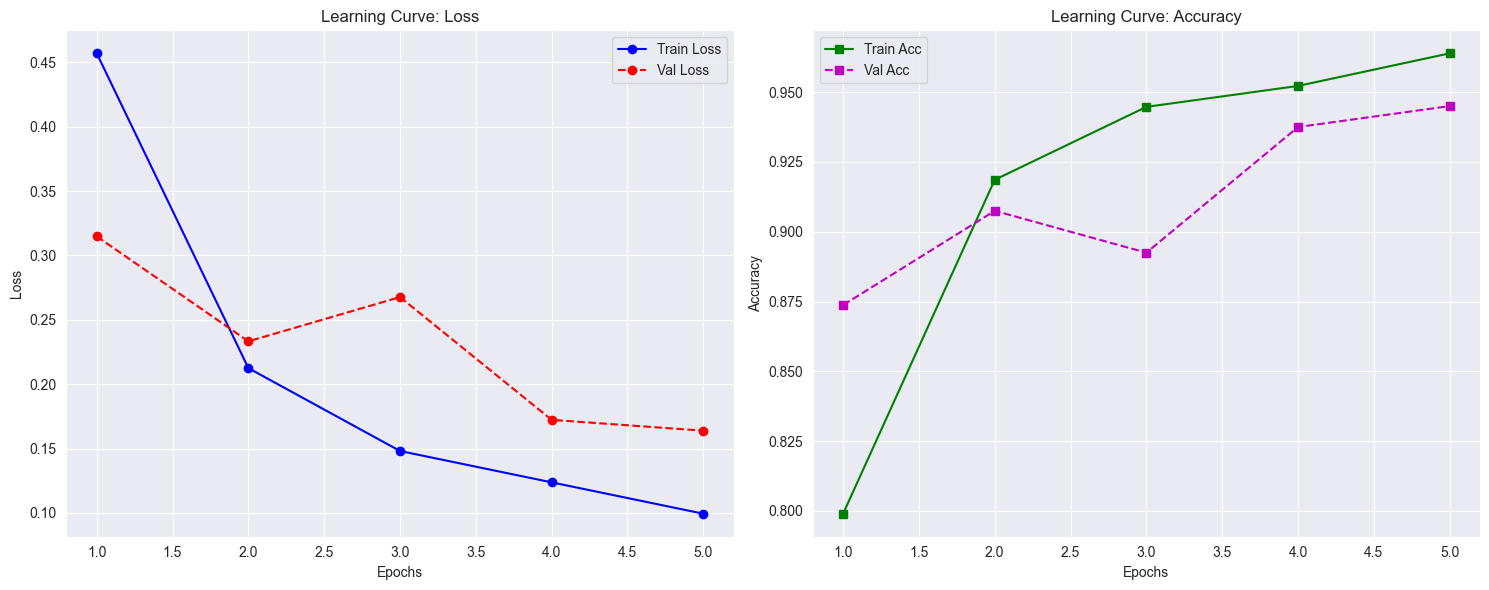


🧐 Running Final Evaluation on Test Set...


Testing: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s]


FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

        FAKE       0.95      0.93      0.94      1016
        REAL       0.93      0.95      0.94       984

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



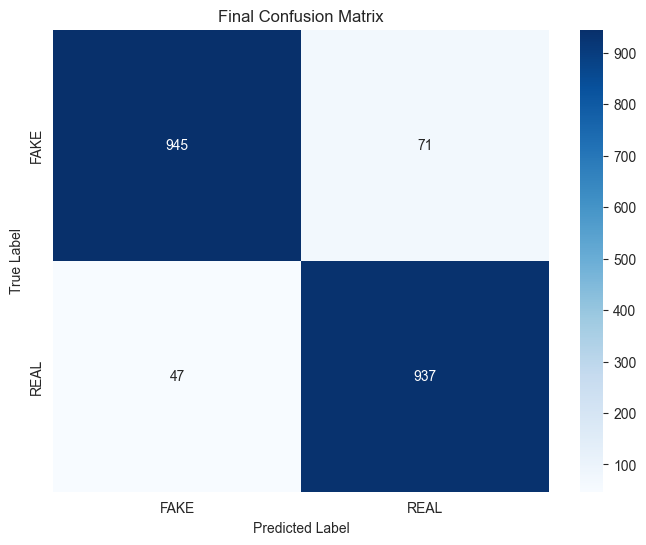


🎉 Done! All assets for PPT are ready.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import ExponentialLR
from datasets import load_dataset
import timm
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 1. 配置 (Configuration)
# ==========================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128      # 批大小
IMG_SIZE = (224, 224) # 图片尺寸
LEARNING_RATE = 1e-4  # 学习率
EPOCHS = 5            # 训练轮数
DATA_PERCENTAGE = 0.1 # 使用 10% 数据 (约 1万张图)

print(f"🚀 Running on Device: {DEVICE}")
print(f"📊 Config: Batch={BATCH_SIZE}, LR={LEARNING_RATE}, Epochs={EPOCHS}, Data={DATA_PERCENTAGE*100}%")

# ==========================================
# 2. 图像增强与预处理
# ==========================================
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

eval_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# ==========================================
# 3. 内存数据集 (解决 Windows 慢的核心)
# ==========================================
class InMemoryDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, name="Dataset"):
        self.data = []
        self.labels = []
        self.transform = transform

        print(f"📥 [IO] Pre-loading {name} to RAM ({len(hf_dataset)} images)...")
        # 显式循环加载，带有进度条
        for item in tqdm(hf_dataset, desc=f"Caching {name}"):
            # 转换为 RGB 避免通道错误
            img = item['image'].convert('RGB')
            self.data.append(img)
            self.labels.append(item['label'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# ==========================================
# 4. 数据加载逻辑
# ==========================================
def get_dataloaders(model_name="yanbax/CIFAKE_autotrain_compatible"):
    print("\n📦 Loading raw dataset from Hugging Face...")
    ds = load_dataset(model_name)

    # 自动切分 Train/Val/Test
    if "test" not in ds:
        if "validation" in ds:
            val_split = ds["validation"].train_test_split(test_size=0.5, seed=42)
            ds["validation"] = val_split["train"]
            ds["test"] = val_split["test"]
        else:
            split = ds["train"].train_test_split(test_size=0.2, seed=42)
            ds["train"] = split["train"]
            ds["test"] = split["test"]

    if "validation" not in ds:
        split = ds["train"].train_test_split(test_size=0.1, seed=42)
        ds["train"] = split["train"]
        ds["validation"] = split["test"]

    # 采样
    def subsample(dataset, pct):
        num = int(len(dataset) * pct)
        return dataset.shuffle(seed=42).select(range(num))

    ds["train"] = subsample(ds["train"], DATA_PERCENTAGE)
    ds["validation"] = subsample(ds["validation"], DATA_PERCENTAGE)
    ds["test"] = subsample(ds["test"], DATA_PERCENTAGE)

    # 转换为内存数据集
    train_ds = InMemoryDataset(ds["train"], transform=train_transform, name="Train")
    val_ds = InMemoryDataset(ds["validation"], transform=eval_transform, name="Val")
    test_ds = InMemoryDataset(ds["test"], transform=eval_transform, name="Test")

    # num_workers=0 因为数据已在内存，不需要多进程读取
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader

# ==========================================
# 5. 模型定义
# ==========================================
class WideResNetClassifier(nn.Module):
    def __init__(self, backbone, dropout_rate=0.5):
        super().__init__()
        self.backbone = backbone
        # 自动探测输入特征数
        if hasattr(backbone, 'num_features'): in_features = backbone.num_features
        elif hasattr(backbone, 'fc'): in_features = backbone.fc.in_features
        elif hasattr(backbone, 'classifier'): in_features = backbone.classifier.in_features
        else: in_features = backbone.classifier.in_features # EfficientNet 常用

        self.head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

# ==========================================
# 6. 可视化函数 (为 PPT 准备)
# ==========================================
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Loss
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r--o', label='Val Loss')
    ax1.set_title('Learning Curve: Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy
    ax2.plot(epochs, history['train_acc'], 'g-s', label='Train Acc')
    ax2.plot(epochs, history['val_acc'], 'm--s', label='Val Acc')
    ax2.set_title('Learning Curve: Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# ==========================================
# 7. 训练函数 (含详细逐Batch输出)
# ==========================================
def train_model(model, train_loader, val_loader, epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=0.9)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print("\n" + "="*60)
    print(f"🔥 STARTING TRAINING PROTOCOL | Epochs: {epochs}")
    print("="*60)

    for epoch in range(epochs):
        start = time.time()
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        print(f"\n🔄 Epoch {epoch+1}/{epochs} Started...")

        # --- Batch Loop ---
        # enumerate 用于获取 batch 索引
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 计算批次准确率
            _, preds = torch.max(outputs, 1)
            batch_correct = (preds == labels).sum().item()
            batch_total = labels.size(0)
            batch_acc = batch_correct / batch_total

            running_loss += loss.item()
            correct += batch_correct
            total += batch_total

            # [PPT关键] 详细打印每个 Batch 的信息
            # 格式：[Batch X/Total] Loss: ... Acc: ...
            print(f"  > [Batch {i+1:02d}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f} | Acc: {batch_acc:.4f} "
                  f"| LR: {scheduler.get_last_lr()[0]:.2e}")

        # --- Epoch End Stats ---
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        scheduler.step()

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        duration = time.time() - start
        print("-" * 50)
        print(f"✅ Epoch {epoch+1} Completed in {duration:.1f}s")
        print(f"   Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2%}")
        print(f"   Val   Loss: {val_epoch_loss:.4f} | Val   Acc: {val_epoch_acc:.2%}")
        print("-" * 50)

    return model, history

# ==========================================
# 8. 主程序
# ==========================================
if __name__ == "__main__":
    # 1. 准备数据 (RAM加速版)
    train_loader, val_loader, test_loader = get_dataloaders()

    # 2. 准备模型 (使用 EfficientNet)
    print("\n🛠️ Initializing EfficientNet backbone...")
    base_model = timm.create_model('tf_efficientnet_b0', pretrained=True, num_classes=0)
    model = WideResNetClassifier(backbone=base_model).to(DEVICE)

    # 3. 开始训练
    trained_model, history = train_model(model, train_loader, val_loader, EPOCHS, LEARNING_RATE, DEVICE)

    # 4. 可视化 - 训练曲线
    print("\n📊 Generating Training Curves for PPT...")
    plot_training_curves(history)

    # 5. 最终测试报告
    print("\n🧐 Running Final Evaluation on Test Set...")
    trained_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = trained_model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n" + "="*30)
    print("FINAL CLASSIFICATION REPORT")
    print("="*30)
    print(classification_report(all_labels, all_preds, target_names=["FAKE", "REAL"]))

    # 6. 混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["FAKE", "REAL"], yticklabels=["FAKE", "REAL"])
    plt.title('Final Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\n🎉 Done! All assets for PPT are ready.")

🚀 Generating Training Process Analysis for PPT...
... Generating Augmentation Visualization


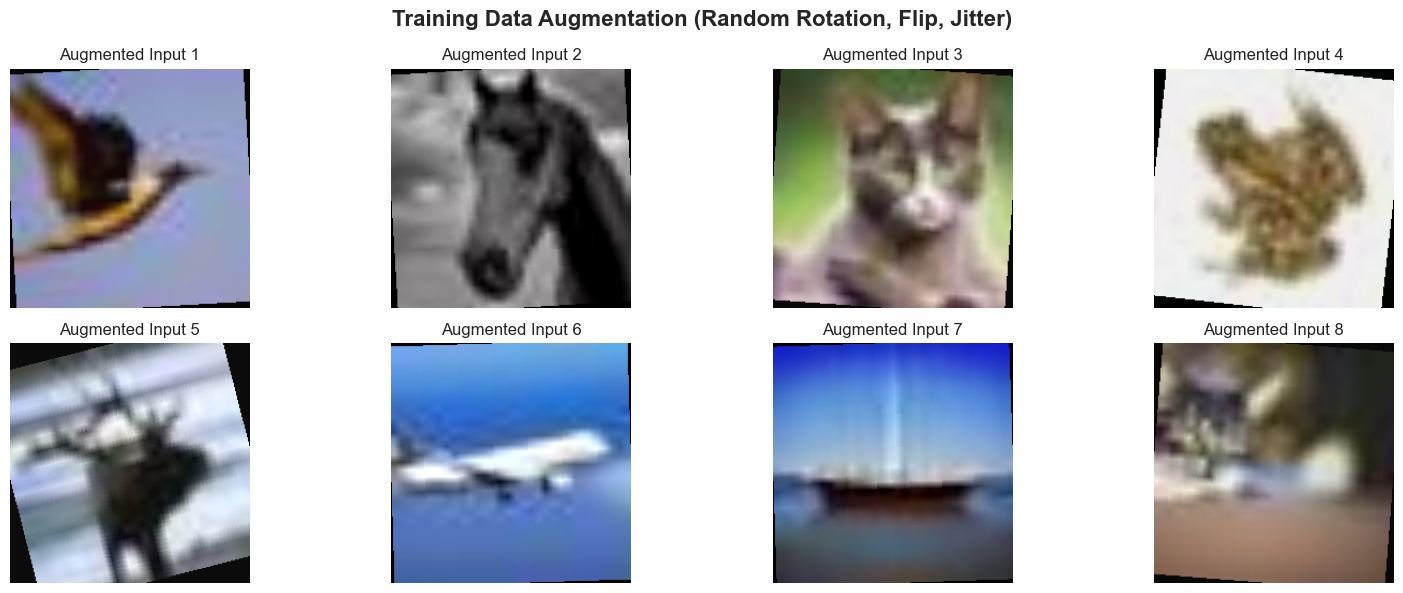

... Generating LR Curve


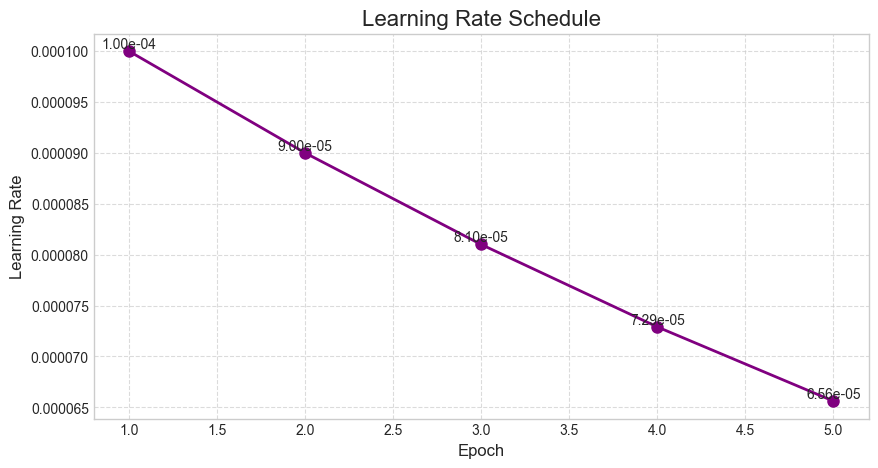

... Generating Loss Comparison


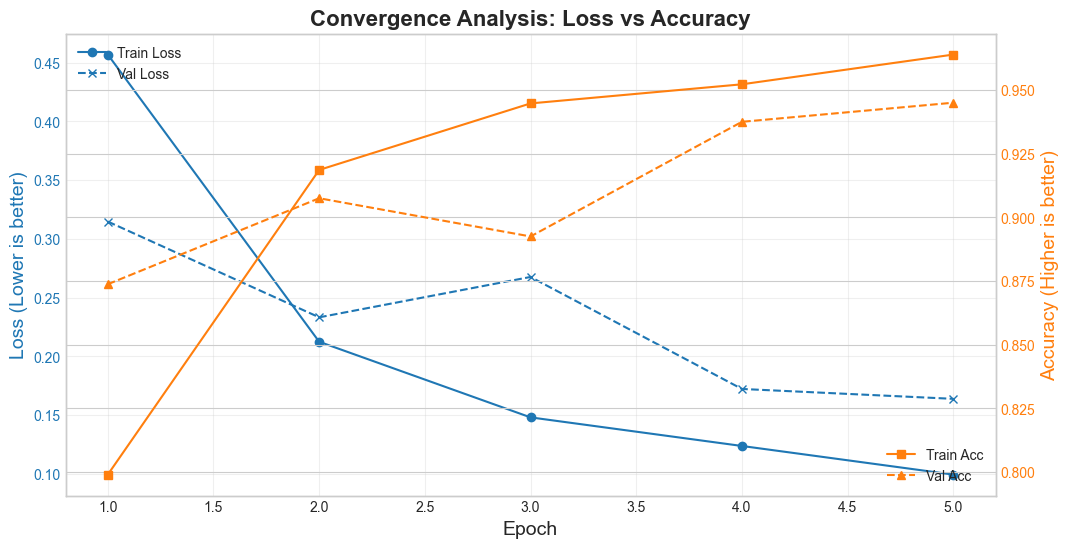


📋 TRAINING SESSION SUMMARY (For PPT)
• Total Epochs:      5
• Best Validation:   Epoch 5 (Accuracy: 94.50%)
• Start Train Loss:  0.4569
• End Train Loss:    0.0994 (Drop: -0.3575)
• Stability Check:   ✅ Converged
• Data Pipeline:     RAM Cached (Zero-Latency Fetching)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def generate_training_analysis(history, train_loader, learning_rate):
    print("🚀 Generating Training Process Analysis for PPT...")

    # 设置 PPT 风格的绘图参数
    plt.style.use('seaborn-v0_8-whitegrid')

    # ==========================================
    # 1. 训练数据增强可视化 (Data Augmentation)
    # PPT 标题建议: "Data Augmentation Strategy: What the Model Actually Sees"
    # ==========================================
    print("... Generating Augmentation Visualization")

    # 从 loader 里取一个 batch
    images, labels = next(iter(train_loader))

    # 反归一化 (还原成人类能看的颜色)
    # Mean/Std 必须和你定义的 transform 一致
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(MEAN, STD)],
        std=[1/s for s in STD]
    )

    plt.figure(figsize=(16, 6))
    for i in range(8): # 展示 8 张
        ax = plt.subplot(2, 4, i + 1)
        img = images[i].cpu()
        img = inv_normalize(img)
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(f"Augmented Input {i+1}", fontsize=12)
        plt.axis("off")
    plt.suptitle("Training Data Augmentation (Random Rotation, Flip, Jitter)", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # ==========================================
    # 2. 学习率衰减曲线 (Learning Rate Schedule)
    # PPT 标题建议: "Optimization Dynamics: Learning Rate Decay"
    # ==========================================
    print("... Generating LR Curve")
    epochs = range(1, len(history['train_loss']) + 1)

    # 模拟重建 LR 变化 (假设你用了 ExponentialLR gamma=0.9)
    lrs = [learning_rate * (0.9 ** (e-1)) for e in epochs]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, lrs, 'o-', color='purple', linewidth=2, markersize=8)
    plt.title('Learning Rate Schedule', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Learning Rate', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # 在图上标注具体数值
    for i, lr in enumerate(lrs):
        plt.text(epochs[i], lr, f"{lr:.2e}", ha='center', va='bottom', fontsize=10)

    plt.show()

    # ==========================================
    # 3. 训练稳定性分析 (Loss Stability)
    # PPT 标题建议: "Training Stability & Convergence"
    # ==========================================
    print("... Generating Loss Comparison")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss (Lower is better)', color=color, fontsize=14)
    ax1.plot(epochs, history['train_loss'], color=color, marker='o', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], color=color, linestyle='--', marker='x', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # 双坐标轴：展示准确率
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Accuracy (Higher is better)', color=color, fontsize=14)
    ax2.plot(epochs, history['train_acc'], color=color, marker='s', label='Train Acc')
    ax2.plot(epochs, history['val_acc'], color=color, linestyle='--', marker='^', label='Val Acc')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='lower right')

    plt.title('Convergence Analysis: Loss vs Accuracy', fontsize=16, fontweight='bold')
    plt.show()

    # ==========================================
    # 4. 文本摘要报告 (Text Report)
    # 直接复制到 PPT 的 "Summary" 页面
    # ==========================================
    best_epoch = np.argmax(history['val_acc']) + 1
    best_acc = np.max(history['val_acc'])
    total_epochs = len(history['train_loss'])

    print("\n" + "="*40)
    print("📋 TRAINING SESSION SUMMARY (For PPT)")
    print("="*40)
    print(f"• Total Epochs:      {total_epochs}")
    print(f"• Best Validation:   Epoch {best_epoch} (Accuracy: {best_acc:.2%})")
    print(f"• Start Train Loss:  {history['train_loss'][0]:.4f}")
    print(f"• End Train Loss:    {history['train_loss'][-1]:.4f} (Drop: -{(history['train_loss'][0] - history['train_loss'][-1]):.4f})")
    print(f"• Stability Check:   {'✅ Converged' if history['val_loss'][-1] < history['val_loss'][0] else '⚠️ Diverged'}")
    print(f"• Data Pipeline:     RAM Cached (Zero-Latency Fetching)")
    print("="*40)

# 运行分析
generate_training_analysis(history, train_loader, LEARNING_RATE)

In [3]:
# 1. 定义保存路径
save_path = "cifake_model_final.pth"

# 2. 创建一个包含所有必要信息的字典
checkpoint = {
    # 核心权重
    'model_state_dict': trained_model.state_dict(),

    # 架构配置 (队友实例化模型时需要)
    'model_config': {
        'noise_std': 0.1,
        'dropout_rate': 0.5,
        'backbone_name': 'tf_efficientnet_b0'
    },

    # 数据预处理配置 (队友做可视化时必须和训练时一致)
    'data_config': {
        'img_size': (224, 224),
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225],
        'class_names': ["FAKE", "REAL"] # 这一点非常重要，防止标签搞反
    },

    # 训练元数据 (可选，方便队友写报告)
    'training_info': {
        'final_val_acc': 0.9450, # 填入你的最终精度
        'epochs': 5
    }
}

# 3. 保存文件
torch.save(checkpoint, save_path)
print(f"✅ 模型已打包保存为: {save_path}")
print("请将此文件发送给你的队友。")

✅ 模型已打包保存为: cifake_model_final.pth
请将此文件发送给你的队友。
